# **Working memory training**: Static connectivity estimation

Step 0:  Loading libraries
--------------------------------

In [2]:
%matplotlib inline


import sys
sys.path.append("..")

import os

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from nilearn import datasets, plotting, input_data, signal  # for fetching atlas

from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nistats.reporting import plot_design_matrix
from nistats.design_matrix import make_first_level_design_matrix
from sklearn.covariance import EmpiricalCovariance

import seaborn as sns
sns.reset_orig()

from fctools import denoise, stats

/home/finc/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/finc/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


Step 1:  Design specification
--------------------------------

/home/finc/anaconda3/lib/python3.7/site-packages/nistats/utils.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


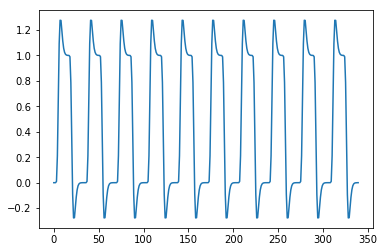

In [3]:
t_r = 2
n_scans = 340

onsets_dir = '/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/support/onsets_dualnback.csv'
events = pd.read_csv(onsets_dir)
frame_times = np.arange(n_scans) * t_r

# Step 1
box = make_first_level_design_matrix(frame_times, events, hrf_model = None)
box = box.reset_index()

# Step 2
box_hrf = make_first_level_design_matrix(frame_times, events, hrf_model = 'glover')
box_hrf  = box_hrf.reset_index()

plt.plot(box_hrf['1-back'])

Step 2: Loading data
----------------------------------------------------


In [4]:
top_dir = '/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/01-extracted_timeseries/'
out_dir = '/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/02-correlation_matrices/'

dual_power = np.load(f'{top_dir}dualnback/LB_dualnback_timeseries_power_denoised_acompcor_no_smooth.npy')
dual_schaefer = np.load(f'{top_dir}dualnback/LB_dualnback_timeseries_schaefer_denoised_acompcor_no_smooth.npy')

rest_power = np.load(f'{top_dir}rest/LB_rest_timeseries_power_denoised_acompcor_no_smooth.npy')
rest_schaefer = np.load(f'{top_dir}rest/LB_rest_timeseries_schaefer_denoised_acompcor_no_smooth.npy')

dual = np.asarray([
                   [dual_power, 'dual_power'], 
                   [dual_schaefer, 'dual_schaefer']])
rest = np.asarray([
                    [rest_power, 'rest_power'], 
                    [rest_schaefer, 'rest_chaefer']])

Step 3: Calculating correlation matrices - resting-state
-------------------------

In [7]:
from sklearn.covariance import EmpiricalCovariance

for p in range(rest.shape[0]):

    data = rest[p,0]
    sub_n = len(data[:, 0, 0, 0])
    ses_n = len(data[0, :, 0, 0])
    rois_n = len(data[0, 0, 0, :])

    correlation_matrices = np.zeros((sub_n, 
                                     ses_n, 
                                     #len(cond), 
                                     rois_n, rois_n))

    for sub in range(sub_n):
        for ses in range(ses_n):                 
            correlation_measure = ConnectivityMeasure(cov_estimator=EmpiricalCovariance(store_precision=True, assume_centered=False), kind = 'correlation', discard_diagonal=True)

            timeseries_dual = data[sub, ses, 0:180, : ] #rect_box_hrf > 0, :]
            #timeseries_dual = (timeseries_dual.T * rect_nnz).T

            fc = correlation_measure.fit_transform([timeseries_dual])[0]
            np.fill_diagonal(fc, 0)

            correlation_matrices[sub, ses, :, :] = np.arctanh(fc)

    print(correlation_matrices.shape)
    np.save(f'{out_dir}static/rest/LB_{rest[p,1]}_static_correlation_matrices.npy', correlation_matrices)


/home/finc/anaconda/lib/python3.6/site-packages/nilearn/connectome/connectivity_matrices.py:359: RuntimeWarning: divide by zero encountered in true_divide
  diagonal = np.atleast_2d(1. / np.sqrt(np.diag(covariance)))
/home/finc/anaconda/lib/python3.6/site-packages/nilearn/connectome/connectivity_matrices.py:360: RuntimeWarning: invalid value encountered in multiply
  correlation = covariance * diagonal * diagonal.T
/home/finc/anaconda/lib/python3.6/site-packages/nilearn/connectome/connectivity_matrices.py:359: RuntimeWarning: divide by zero encountered in true_divide
  diagonal = np.atleast_2d(1. / np.sqrt(np.diag(covariance)))
/home/finc/anaconda/lib/python3.6/site-packages/nilearn/connectome/connectivity_matrices.py:360: RuntimeWarning: invalid value encountered in multiply
  correlation = covariance * diagonal * diagonal.T


(46, 4, 300, 300)


Step 4: Calculating correlation matrices - dual n-back
-------------------------

In [8]:
for p in range(rest.shape[0]):
    data = dual[p,0]
    
    sub_n = len(data[:, 0, 0, 0])
    ses_n = len(data[0, :, 0, 0])
    cond = ['1-back', '2-back']
    rois_n = len(data[0, 0, 0, :])
    A = np.zeros((rois_n, rois_n))
    correlation_matrices_wei = np.zeros((sub_n, ses_n, len(cond), rois_n, rois_n))


    for sub in range(sub_n):
        print(f'Calculating correlations: sub {sub}')
        for ses in range(ses_n):                 
            for con in range(len(cond)):
                #--- zeroing negative values
                rect_box_hrf = np.array([0 if elem < 0 else elem for elem in box_hrf[cond[con]]])
                #--- concatenating nonzeros blocs
                rect_nnz = rect_box_hrf[np.nonzero(rect_box_hrf)]
                #--- filtering            
                timeseries_dual = data[sub, ses, rect_box_hrf > 0, :]
                #--- calculating weighted correlation coefficient
                for i in range(rois_n):
                    for j in range(i):
                        if i == j:
                            continue
                        else:
                            A[i, j] = stats.corr_wei(timeseries_dual[:, i], timeseries_dual[:, j], rect_nnz)

                fc = A + A.T
                correlation_matrices_wei[sub, ses, con, :, :] = np.arctanh(fc)
    print(correlation_matrices_wei.shape)
    np.save(f'{out_dir}static/dualnback/LB_{dual[p,1]}_static_correlation_matrices.npy', correlation_matrices_wei)

Calculating correlations: sub 0
Calculating correlations: sub 1
Calculating correlations: sub 2
Calculating correlations: sub 3
Calculating correlations: sub 4
Calculating correlations: sub 5
Calculating correlations: sub 6
Calculating correlations: sub 7
Calculating correlations: sub 8
Calculating correlations: sub 9
Calculating correlations: sub 10
Calculating correlations: sub 11
Calculating correlations: sub 12
Calculating correlations: sub 13
Calculating correlations: sub 14
Calculating correlations: sub 15
Calculating correlations: sub 16
Calculating correlations: sub 17
Calculating correlations: sub 18
Calculating correlations: sub 19
Calculating correlations: sub 20
Calculating correlations: sub 21
Calculating correlations: sub 22
Calculating correlations: sub 23
Calculating correlations: sub 24
Calculating correlations: sub 25
Calculating correlations: sub 26
Calculating correlations: sub 27
Calculating correlations: sub 28
Calculating correlations: sub 29
Calculating correlat